In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.model_selection import train_test_split

In [2]:
def confusionMatrix(pred_labels,actual_labels,label_dict):
    labels = [label_dict[i] for i in label_dict.keys()]
    M = actual_labels.shape[0]
    tmp = np.array([np.arange(M,dtype =np.int32)+1,pred_labels,actual_labels]).T
    result = pd.DataFrame(data = tmp, columns=['ImageId', 'Predicted_Label','Actual_Label'])
    n = 5
    conf = np.zeros([n,n],dtype = np.int32)
    for i in range(n):
        for j in range(n):
            conf[i,j] = np.sum(result[result["Actual_Label"] == i]["Predicted_Label"] == j)
    confusion = pd.DataFrame(conf,index=labels,columns=labels)
    pd.Series.__unicode__ = pd.Series.to_string
    return confusion

# Decision Tree Learning

Starting at the root we choose a feature to split on based on the largest Information Gain.

$$IG(D_p,f)=I(D_p)-\sum_{j=1}^m\frac{N_j}{N_p}I(D_j)$$

Where $f$- denotes the feature to perform split.

$D_p$ and $D_j$-denote the data set of the parent and child nodes respectively.

$N_p$ and $N_j$ are the total number of samples at the parent and child nodes respectively.

$I$ is the impurity measure.

Thus, the information gain is the difference in the impurity of the parent node and the sum of the impurities in the child node. The lower the impurity of the child nodes the larger the information gain.

Typically a binary decision tree is used yielding the following information gain.

$$IG(D_p,f)=I(D_p)-\frac{N_{left}}{N_p}I(D_{left})-\frac{N_{right}}{N_p}I(D_{right})$$

Common impurity measures are the Gini impurity ($I_G$), entrophy ($I_H$), and the classification error ($I_E$) and they are defined below.

Let $p(i|t)$- denote the proportion of the samples that belongs to class $i$ for a particular node $t$.

$$I_G(t) = \sum_{i=1}^c p(i|t)(1-p(i|t))=1-\sum_{i=1}^c p(i|t)^2$$
Properties:
    
    The Gini index attempts to minimize the probability of missclassification
    
    The Gini index is also zero if all samples belong to the same class.
    
    The Gini index is also maximal if the clases are distributed evenly.


$$I_H(t)=-\sum_{i=1}^c p(i|t)\log_2 p(i|t)$$
Properties:

    If all the samples in the same node all belong to the same class then the impurity is 0.

    The entropy is maximal if we have a uniform class distribution.


$$I_E(t) = 1-\max\{p(i|t)\}$$
Properties:

    The classification error is also 0 if they all belong to same class.
    
    The classification error is also maximal for equal distribution of classes.
    
    Not recommended for growing but good for pruning the tree. 
    Due to its lower sentivity to changes in the class probabilities. (see PML pg 84 for example)

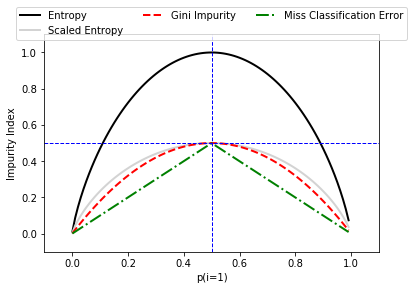

In [3]:
# Here we analyze the impurity indices sensitivity (supposing 2 class)
#Define our 3 impurity indices for comparision
#Note they are specified for a 2 class problem
def Entropy(p):
    return -p*np.log2(p)-(1-p)*np.log2(1-p)
#1-p^2-(1-p)^2
def Gini(p):
    return 2*p*(1-p)
#Return the smaller probability
def MissClass(p):
    if(p > 1-p):
        return 1-p
    else:
        return p

x = np.arange(0.001,1.0,0.01)
ent =[Entropy(p) for p in x]
scaleEnt = [.5*j for j in ent]
gini = [Gini(p) for p in x]
mc = [MissClass(p) for p in x]

fig = plt.figure()
ax = plt.subplot()
#This loop plots one index at a time
for i, lab, ls, c, in zip([ent, scaleEnt,gini,mc]
                          ,['Entropy','Scaled Entropy','Gini Impurity','Miss Classification Error']
                         ,['-','-','--','-.']
                         ,['black','lightgray','red','green','cyan']):
        line = ax.plot(x, i, label = lab, linestyle = ls, lw =2, color = c)
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5,1.15),ncol = 3, fancybox = True, shadow = False)
ax.axhline(y=0.5,linewidth =1,color ='b', linestyle = '--')
ax.axvline(x=0.5,linewidth=1,color = 'b',linestyle = '--')
plt.ylim([-0.1,1.1])
plt.xlim([-0.1,1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
plt.savefig('Impurity.png')
plt.show()

In [4]:
housing_dir = "./../Data/housing.csv"

In [5]:
data = pd.read_csv(housing_dir,sep = ",",dtype = {'ocean_proximity': str})
# To check the data types of the different columns:
data.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

In [6]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
data.describe().drop('count').round(decimals=2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
mean,-119.57,35.63,28.64,2635.76,537.87,1425.48,499.54,3.87,206855.82
std,2.00,2.14,12.59,2181.62,421.39,1132.46,382.33,1.90,115395.62
min,-124.35,32.54,1.00,2.00,1.00,3.00,1.00,0.50,14999.00
25%,-121.80,33.93,18.00,1447.75,296.00,787.00,280.00,2.56,119600.00
50%,-118.49,34.26,29.00,2127.00,435.00,1166.00,409.00,3.53,179700.00
75%,-118.01,37.71,37.00,3148.00,647.00,1725.00,605.00,4.74,264725.00
max,-114.31,41.95,52.00,39320.00,6445.00,35682.00,6082.00,15.00,500001.00


In [8]:
(data['ocean_proximity'].value_counts()/data.shape[0]*100).round(2)

<1H OCEAN     44.26
INLAND        31.74
NEAR OCEAN    12.88
NEAR BAY      11.09
ISLAND         0.02
Name: ocean_proximity, dtype: float64

In [9]:
data.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [10]:
data.shape

(20640, 10)

In [11]:
data = data.dropna()
data.shape

(20433, 10)

In [12]:
Y = pd.get_dummies(data['ocean_proximity']).as_matrix()
Y = np.argmax(Y,axis=1)

In [13]:
X = data.drop(columns = ['ocean_proximity']).as_matrix()

In [14]:
X_train, X_test,Y_train,Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 123)

In [15]:
tree = DecisionTreeClassifier(criterion = 'gini', max_depth = 2, random_state =123)
tree.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')

In [16]:
preds = tree.predict(X_train)
print("Training Accuracy: {:.2f}%".format(100*np.sum(preds==Y_train)/Y_train.shape[0]))

Training Accuracy: 69.83%


In [17]:
preds = tree.predict(X_test)
print("Testing Accuracy: {:.2f}%".format(100*np.sum(preds==Y_test)/Y_test.shape[0]))

Testing Accuracy: 68.88%


In [18]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("input.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

In [19]:
visualize_tree(tree,data.drop(columns = ['ocean_proximity']).columns.values)

## Go to directory that the dot file was saved and type

dot -Tpng input.dot > output.png

In [20]:
tree = DecisionTreeClassifier(criterion = 'gini', max_depth = 15, random_state =123)
tree.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')

In [21]:
preds = tree.predict(X_train)
print("Training Accuracy: {:.2f}%".format(100*np.sum(preds==Y_train)/Y_train.shape[0]))

Training Accuracy: 99.99%


In [22]:
preds = tree.predict(X_test)
print("Testing Accuracy: {:.2f}%".format(100*np.sum(preds==Y_test)/Y_test.shape[0]))

Testing Accuracy: 97.85%


In [23]:
data['ocean_proximity'].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'], dtype=object)

In [24]:
ocean_dict = {0: '<1H OCEAN', 1: 'INLAND', 2: 'ISLAND',3:'NEAR BAY', 4:'NEAR OCEAN'}

In [25]:
confusionMatrix(preds,Y_test,ocean_dict)

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
<1H OCEAN,1788,17,0,1,15
INLAND,16,1281,0,0,1
ISLAND,0,0,1,0,0
NEAR BAY,2,0,0,430,3
NEAR OCEAN,29,0,0,4,499
